In [1]:
!pip install noise

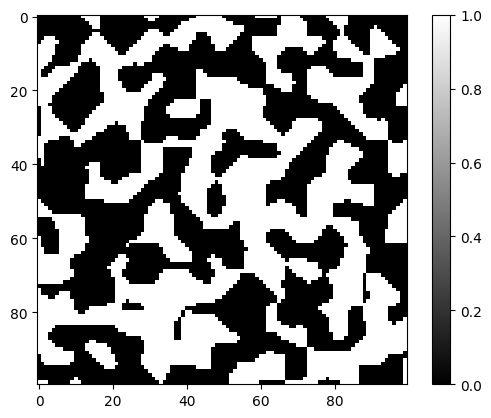

In [12]:
import numpy as np
from noise import snoise3
import matplotlib.pyplot as plt

def generate_perlin_noise(width, height, depth, scale, threshold):
    # Create a grid of coordinates
    x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.arange(depth), indexing='ij')

    # Scale the coordinates
    x_scaled, y_scaled, z_scaled = x * scale, y * scale, z * scale

    # Vectorized call to snoise3
    noise_array = np.vectorize(snoise3)(x_scaled, y_scaled, z_scaled)

    # Threshold the noise
    thresholded_array = np.where(noise_array > threshold, 1, 0)

    return thresholded_array

# Parameters
width, height, depth = 100, 100, 100
scale = 0.09
threshold = 0.0

# Generate and visualize the thresholded Perlin noise
thresholded_array = generate_perlin_noise(width, height, depth, scale, threshold)

# Visualize a 2D slice of the 3D data
plt.imshow(thresholded_array[:, :, 50], cmap='gray')  # Change 50 to view a different depth slice
plt.colorbar()
plt.show()


In [13]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

In [14]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

In [15]:
imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/IXI_test.csv'
csvpath_test_lesion = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test','test_lesion']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
var_csv['test_lesion'] = pd.read_csv(csvpath_test_lesion)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    var_csv[state]['seg_path'] =  var_csv[state]['mask_path']


data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)
data_test_lesion = Eval(var_csv['test_lesion'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
#train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)

test_lesion_loader = DataLoader(data_test_lesion, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)
device = torch.device("cuda")

In [16]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [17]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/half/model_epoch549.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

In [18]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2



dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([38.9000], dtype=torch.float64)


In [19]:
import torch

# Example tensor of shape (batch_size, channels, height, width, depth)
image_tensor = image_array[0:1,:,:,:,:]+0


# Coordinates for the patch you want to remove
start_h, start_w, start_d = 30, 30, 30
end_h, end_w, end_d = 50, 50, 50



# "Remove" the patch from the image by setting it to zeros (or any other value)
image_tensor[:, :, start_h:end_h, start_w:end_w, start_d:end_d] = 1

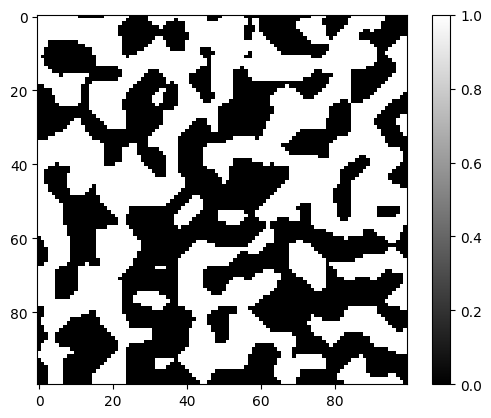

In [20]:
# Parameters
_,_,width, height, depth = image_tensor.size()
scale = 0.09 # Adjust this to change the "frequency" of the noise
threshold = 0.0  # Since Perlin noise returns values between -1 and 1, a threshold of 0 should roughly split the values

# Generate 3D Perlin noise
noise_array = np.empty((width, height, depth))
for x in range(width):
    for y in range(height):
        for z in range(depth):
            noise_array[x, y, z] = snoise3(x * scale, y * scale, z * scale)

# Threshold the noise
mask = np.where(noise_array > threshold, 1, 0)

# For visualization: Show a 2D slice of the 3D data
plt.imshow(thresholded_array[:, :, middle_slice_idx], cmap='gray')  # Change 50 to view a different depth slice
plt.colorbar()
plt.show()


In [21]:
model.eval()
import torch

# Convert the NumPy array to a PyTorch tensor
mask_tensor = torch.tensor(mask).float()

# Now move the tensor to the desired device
mask= mask_tensor.to(device)
import tqdm as tqdm
mask = mask.to(device)
val_image_masked = image_tensor.to(device)*mask
val_image_inpainted = torch.randn_like(val_image_masked).to(device)
timesteps = torch.Tensor((999,)).to(mask.device).long()
scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(val_image_masked).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked
                
                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(val_image_masked).to(device)
                    val_image_inpainted = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )


100%|██████████| 999/999 [04:30<00:00,  3.69it/s]


Text(0.5, 1.0, 'denoised Image inpaint')

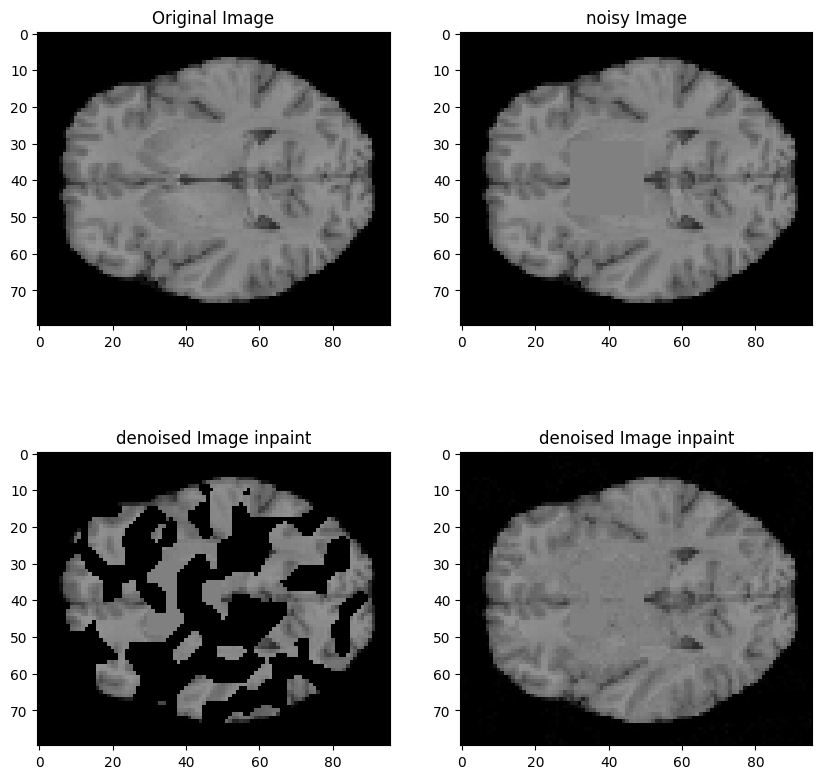

In [22]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image_array[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[0, 1].imshow(image_tensor[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('noisy Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[1, 0].imshow(val_image_masked[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('denoised Image inpaint')

axes[1, 1].imshow(val_image_inpainted[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 1].set_title('denoised Image inpaint')


In [24]:
mask_1 = 1-mask.to(device)

In [25]:
val_image_masked_1 = val_image_inpainted.to(device)*mask_1
val_image_inpainted_1 = torch.randn_like(val_image_masked_1).to(device)
timesteps = torch.Tensor((999,)).to(noise.device).long()
scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(val_image_masked_1).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked_1, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked_1
                
                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted_1, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted_1)

                # combine known and unknown using the mask
                val_image_inpainted_1 = torch.where(
                    mask_1 == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(val_image_masked_1).to(device)
                    val_image_inpainted_1 = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted_1
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )

100%|██████████| 999/999 [04:30<00:00,  3.70it/s]


Text(0.5, 1.0, 'denoised Image inpaint')

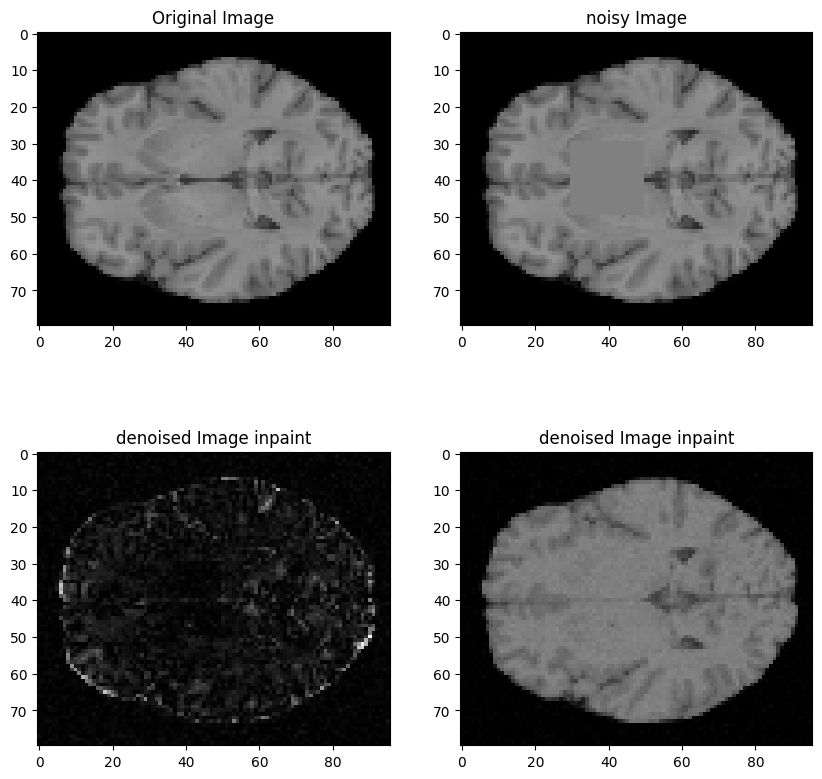

In [31]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image_array[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[0, 1].imshow(image_tensor[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('noisy Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original 
error = torch.abs(val_image_inpainted_1-image_tensor)
axes[1, 0].imshow(error[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
axes[1, 0].set_title('denoised Image inpaint')

axes[1, 1].imshow(val_image_inpainted_1[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 1].set_title('denoised Image inpaint')


In [ ]:
import torch

def generate_3d_checkerboard(size, block_size):
    """
    Generate a 3D checkerboard mask using PyTorch.

    :param size: The size of the 3D tensor (depth, height, width)
    :param block_size: Size of each block in the checkerboard
    :return: 3D tensor of shape `size`
    """
    
    depth, height, width = size
    pattern = torch.arange(depth * height * width).reshape(depth, height, width)
    checkerboard = ((pattern // block_size) % 2) ^ ((pattern // (block_size * depth)) % 2) ^ ((pattern // (block_size * depth * height)) % 2)
    
    return checkerboard

# Example usage
_,_,width, height, depth = image_tensor.size()
size = width, height, depth
block_size = 2
mask = generate_3d_checkerboard(size, block_size)
print(mask)
